# Анализ продаж интернет-магазина «В один клик»

**Описание проекта:** Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.

**Цель исследования:** Необходимо разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

**Ход исследования:**

- Нужно построить модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца.
- В исследование нужно включить дополнительные данные финансового департамента о прибыльности клиента: какой доход каждый покупатель приносил компании за последние три месяца.
- Используя данные модели и данные о прибыльности клиентов, нужно выделить сегменты покупателей и разработать для них персонализированные предложения.

**Общий вывод:** резюмирование полуенных результатов, формулировка ключевых выводов и результатов.

In [1]:
!pip install -q --upgrade scikit-learn
!pip install matplotlib==3.7.3 -q
!pip install -q --upgrade numba
!pip install -q --upgrade shap
!pip install phik -q

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
from phik.report import plot_correlation_matrix
from phik import phik_matrix
import shap

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    OneHotEncoder, 
    OrdinalEncoder, 
    StandardScaler, 
    MinMaxScaler, 
    LabelEncoder
)
from sklearn.impute import SimpleImputer

warnings.filterwarnings("ignore", category=FutureWarning)

# загружаем нужные модели
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

# загружаем функцию для работы с метриками
from sklearn.metrics import roc_auc_score

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [3]:
def plot_histograms_boxplots(df):
    """
    Строит гистограммы и ящики с усами для каждого количественного фактора в DataFrame.

    :param df: DataFrame, содержащий данные
    """
    # Выбор числовых столбцов
    numeric_cols = df.select_dtypes(include=['number']).columns

    # Установка размера фигуры
    num_plots = len(numeric_cols)
    plt.figure(figsize=(10, 5 * num_plots))

    # Построение гистограмм и ящиков с усами для каждого числового столбца
    for i, col in enumerate(numeric_cols):
        # Гистограмма
        plt.subplot(num_plots, 2, 2*i + 1)
        df[col].hist(bins=15)
        plt.title(f'Histogram of {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')

        # Ящик с усами
        plt.subplot(num_plots, 2, 2*i + 2)
        df.boxplot(column=col)
        plt.title(f'Box Plot of {col}')

    plt.tight_layout()
    plt.show()

In [4]:
def plot_countplots(df):
    """
    Строит countplots для каждого категориального фактора в DataFrame.

    :param df: DataFrame, содержащий данные.
    """
    # Выбор категориальных столбцов
    categorical_cols = df.select_dtypes(exclude=['number']).columns

    # Установка размера фигуры
    num_plots = len(categorical_cols)
    plt.figure(figsize=(10, 5 * num_plots))

    # Построение countplots для каждого категориального столбца
    for i, col in enumerate(categorical_cols):
        plt.subplot(num_plots, 1, i + 1)
        sns.countplot(y=col, data=df)
        plt.title(f'График {col}')
        plt.xlabel(col)
        plt.ylabel('Количество')

    plt.tight_layout()
    plt.show()

In [5]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

## Загрузка данных

### Считаем данные

In [6]:
market_file = pd.read_csv('market_file.csv', sep = ',')
market_money = pd.read_csv('market_money.csv', sep = ',')
market_time = pd.read_csv('market_time.csv', sep = ',')
money = pd.read_csv('money.csv', sep = ';', decimal = ',')

### Проверка данных

In [7]:
display(market_file.head())
market_file.info()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

In [8]:
display(market_money.head())
market_money.info()

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


In [9]:
display(market_time.head())
market_time.info()

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


In [10]:
display(money.head())
money.info()

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


***Вывод:***
Данные соответствуют описанию.

## Предобработка данных

### Скорректируем название столбцов к snake_case

In [11]:
market_file = market_file.rename(
    columns={'Покупательская активность': 'покуп_актив', 'Тип сервиса': 'тип_сервиса',
             'Разрешить сообщать': 'разр_сообщать', 'Маркет_актив_6_мес': 'маркет_актив_6_мес',
             'Маркет_актив_тек_мес': 'маркет_актив_тек_мес', 'Длительность': 'длительность',
             'Акционные_покупки': 'акци_покупки', 'Популярная_категория': 'поп_категория',
             'Средний_просмотр_категорий_за_визит': 'сред_просм_катег_за_визит',
             'Неоплаченные_продукты_штук_квартал': 'неопл_прод_штук_квартал',
             'Ошибка_сервиса': 'ошибка_сервиса', 'Страниц_за_визит': 'страниц_за_визит'
            }
)

In [12]:
market_money = market_money.rename(columns={'Период': 'период_деньги', 'Выручка': 'выручка'})

In [13]:
market_time = market_time.rename(columns={'Период': 'период_время'})

In [14]:
money = money.rename(columns={'Прибыль': 'прибыль'})

### Проверим на дубликаты

In [15]:
_cat_data = ['покуп_актив', 'тип_сервиса', 'разр_сообщать', 'поп_категория']
for col in _cat_data:
    print(market_file[col].unique())

['Снизилась' 'Прежний уровень']
['премиум' 'стандартт' 'стандарт']
['да' 'нет']
['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника']


In [16]:
market_file['поп_категория'] = market_file['поп_категория'].replace({'Косметика и аксесуары': 'Косметика и аксессуары'})
market_file['поп_категория'].unique()

array(['Товары для детей', 'Домашний текстиль', 'Косметика и аксессуары',
       'Техника для красоты и здоровья', 'Кухонная посуда',
       'Мелкая бытовая техника и электроника'], dtype=object)

In [17]:
market_file['тип_сервиса'] = market_file['тип_сервиса'].replace({'стандартт': 'стандарт'})
market_file['тип_сервиса'].unique()

array(['премиум', 'стандарт'], dtype=object)

In [18]:
market_file.duplicated().sum()

0

In [19]:
market_money['период_деньги'].unique()

array(['препредыдущий_месяц', 'текущий_месяц', 'предыдущий_месяц'],
      dtype=object)

In [20]:
market_money.duplicated().sum()

0

In [21]:
market_time['период_время'].unique()

array(['текущий_месяц', 'предыдцщий_месяц'], dtype=object)

In [22]:
market_time['период_время'] = market_time['период_время'].replace({'предыдцщий_месяц': 'предыдущий_месяц'})
market_time['период_время'].unique()

array(['текущий_месяц', 'предыдущий_месяц'], dtype=object)

In [23]:
market_time.duplicated().sum()

0

***Вывод:***
В данных выявлены некоторые опечатки, а именно:
- в market_file в столбце "тип_сервиса" кое-где стандарт был написан с двумя "т" на конце;
- в market_time в столбце "период" кое-где предыдущий был написан с ошибкой.

Дубликатов не выявлено.

## Исследовательский анализ данных

### Определим функции для анализа данных

Для исключения id из анализа, сделаем его индексом.

### Изучим статистики всех таблиц и выбросы с помощью диаграммы "ящик с усами"

In [24]:
market_file = market_file.set_index('id')
market_money = market_money.set_index('id')
market_time = market_time.set_index('id')
money = money.set_index('id')

In [25]:
market_file.describe()

,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акци_покупки,сред_просм_катег_за_визит,неопл_прод_штук_квартал,ошибка_сервиса,страниц_за_визит
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.00000,1300.000000,1300.000000,1300.000000
mean,4.253769,4.011538,601.898462,0.319808,3.27000,2.840000,4.185385,8.176923
std,1.014814,0.696868,249.856289,0.249843,1.35535,1.971451,1.955298,3.978126
min,0.900000,3.000000,110.000000,0.000000,1.00000,0.000000,0.000000,1.000000
25%,3.700000,4.000000,405.500000,0.170000,2.00000,1.000000,3.000000,5.000000
50%,4.200000,4.000000,606.000000,0.240000,3.00000,3.000000,4.000000,8.000000
75%,4.900000,4.000000,806.000000,0.300000,4.00000,4.000000,6.000000,11.000000
max,6.600000,5.000000,1079.000000,0.990000,6.00000,10.000000,9.000000,20.000000


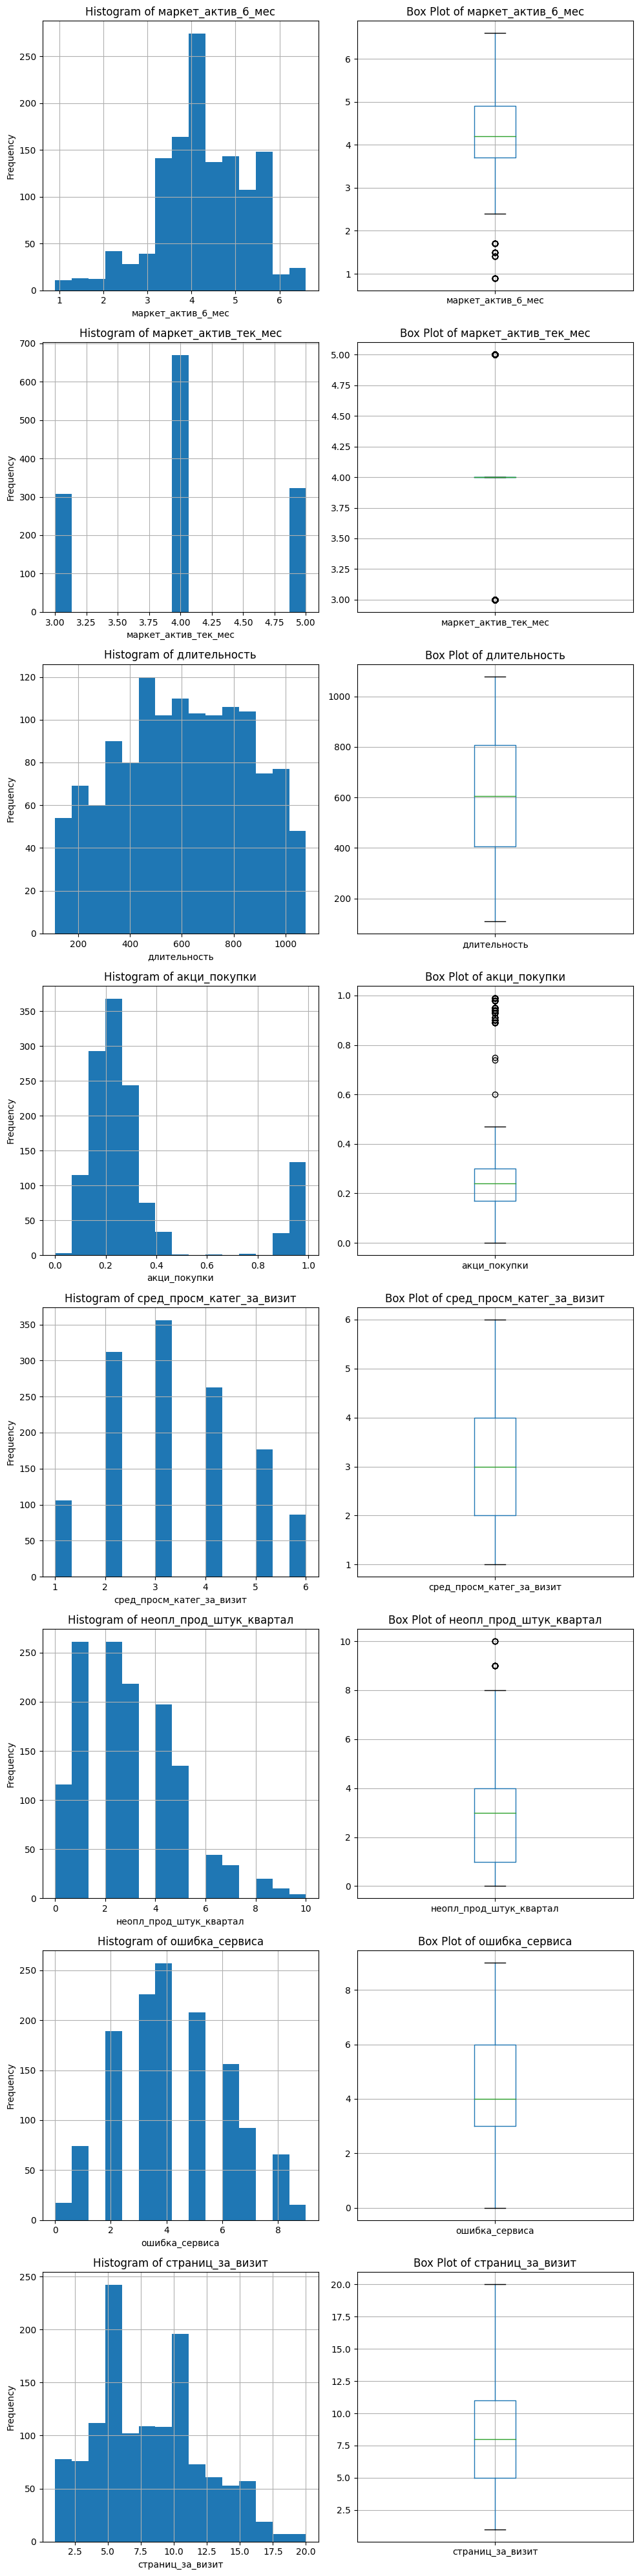

In [26]:
plot_histograms_boxplots(market_file)

В параметрах маркет_актив_6_мес, акци_покупки, неопл_прод_штук_квартал присутствуют выбросы. Диаграмма для параметра маркет_актив_тек_мес выглядит так потому что уникальных значений всего 3.

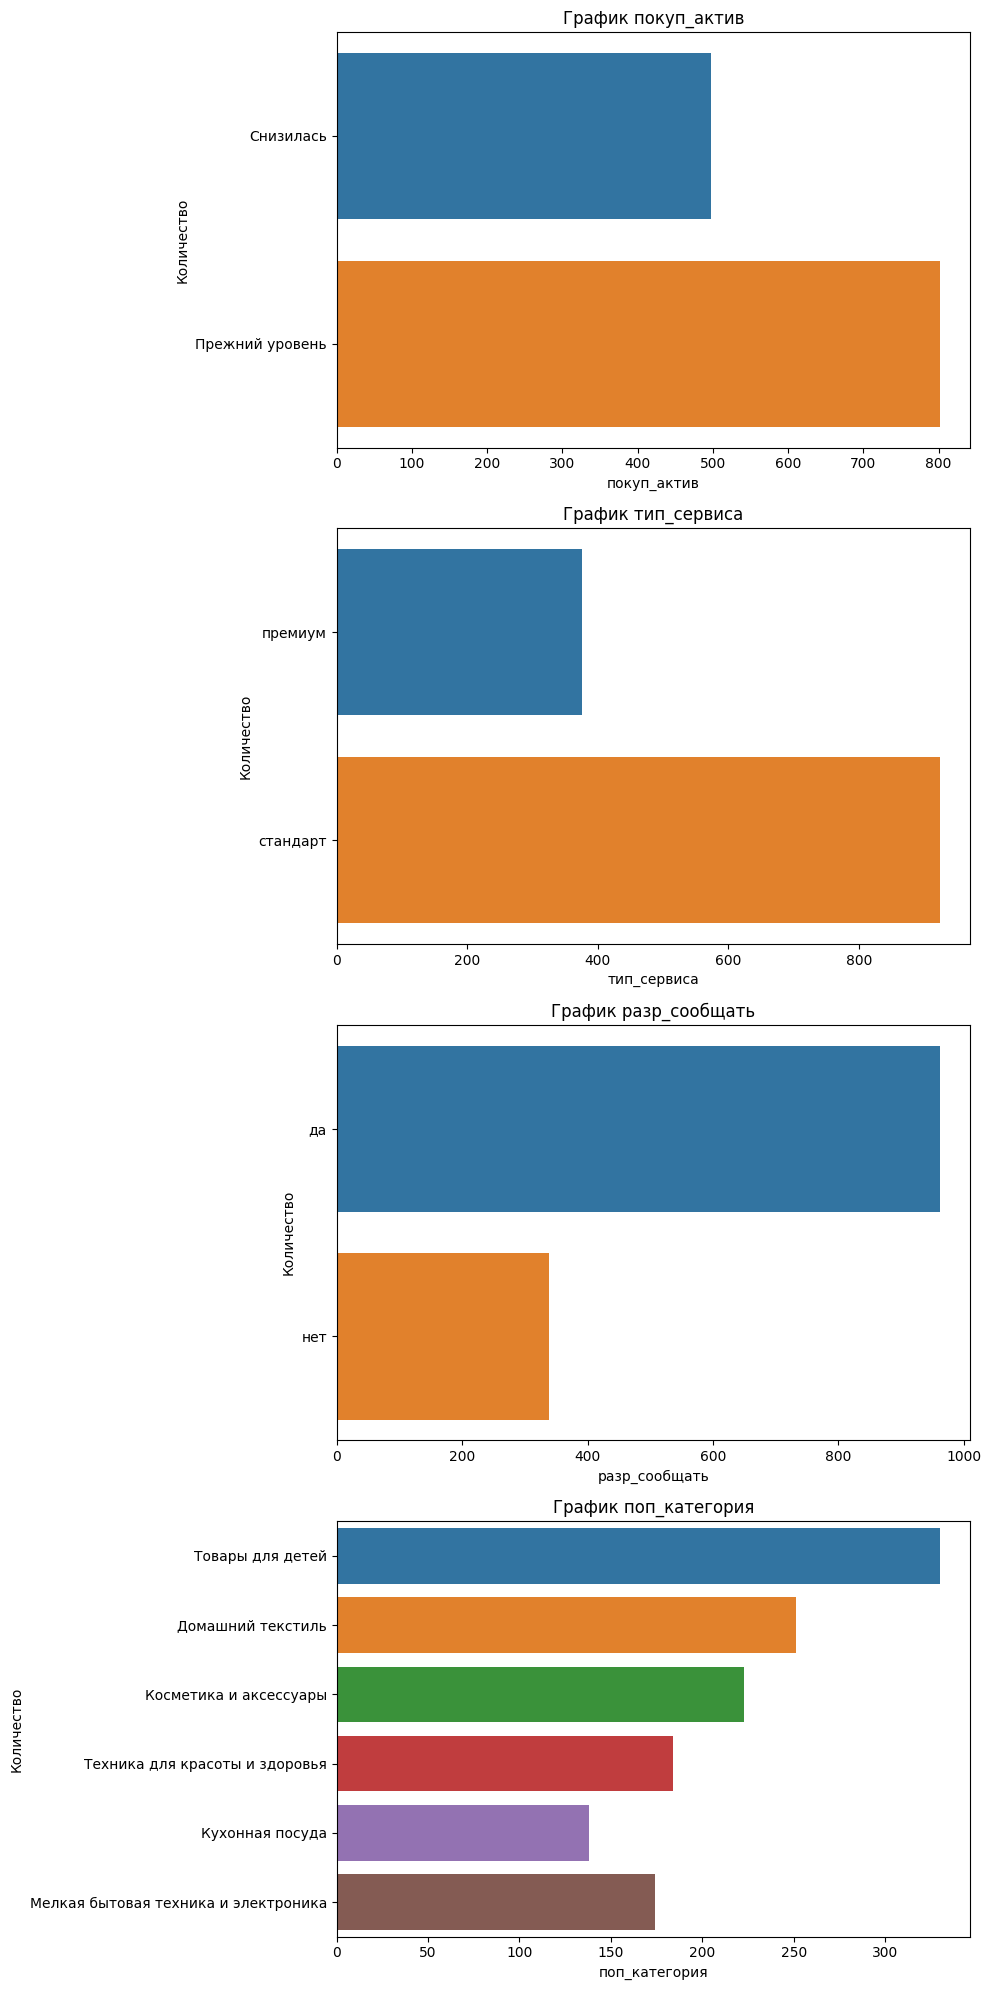

In [27]:
plot_countplots(market_file)

В параметрах: тип_сервиса и разр_сообщать виден дисбаланс в значениях. Тажке он есть и в целевом признаке покуп_актив.

In [28]:
market_money.describe()

,выручка
count,3900.000000
mean,5025.696051
std,1777.704104
min,0.000000
25%,4590.150000
50%,4957.500000
75%,5363.000000
max,106862.200000


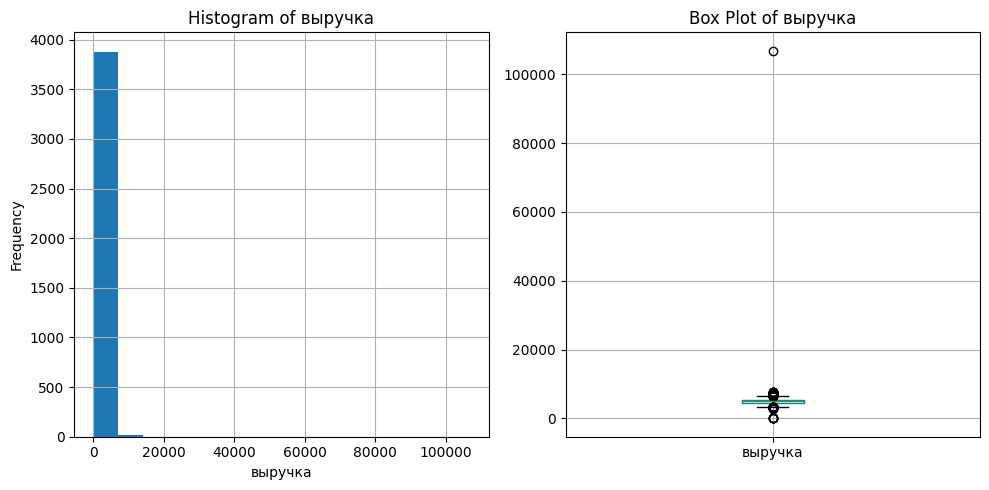

In [29]:
plot_histograms_boxplots(market_money)

В диаграмме выручка присутствует сильный выброс, который искажает диаграмму. Удалим его.

In [30]:
market_money.sort_values(by='выручка', ascending=False).head()

,период_деньги,выручка
id,,
215380,текущий_месяц,106862.2
215493,текущий_месяц,7799.4
215435,текущий_месяц,7605.3
215841,текущий_месяц,7557.0
216144,текущий_месяц,7547.8


In [31]:
market_money[market_money['выручка'] == 106862.2]

,период_деньги,выручка
id,,
215380,текущий_месяц,106862.2


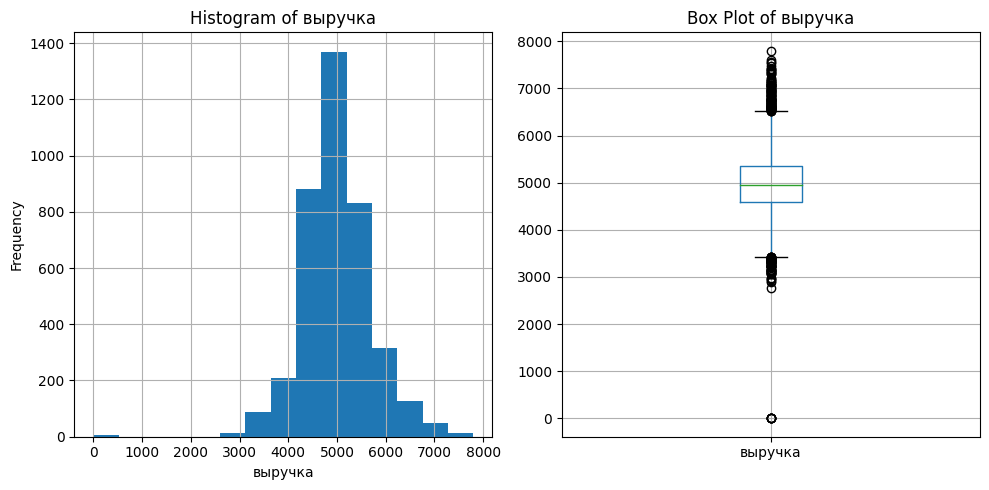

In [32]:
market_money = market_money[market_money['выручка'] != 106862.2]
plot_histograms_boxplots(market_money)

Теперь значение 0 похоже на вброс. Удалим его тоже.

In [33]:
market_money[market_money['выручка'] == 0]

,период_деньги,выручка
id,,
215348,препредыдущий_месяц,0.0
215348,предыдущий_месяц,0.0
215357,препредыдущий_месяц,0.0
215357,предыдущий_месяц,0.0
215359,предыдущий_месяц,0.0
215359,препредыдущий_месяц,0.0


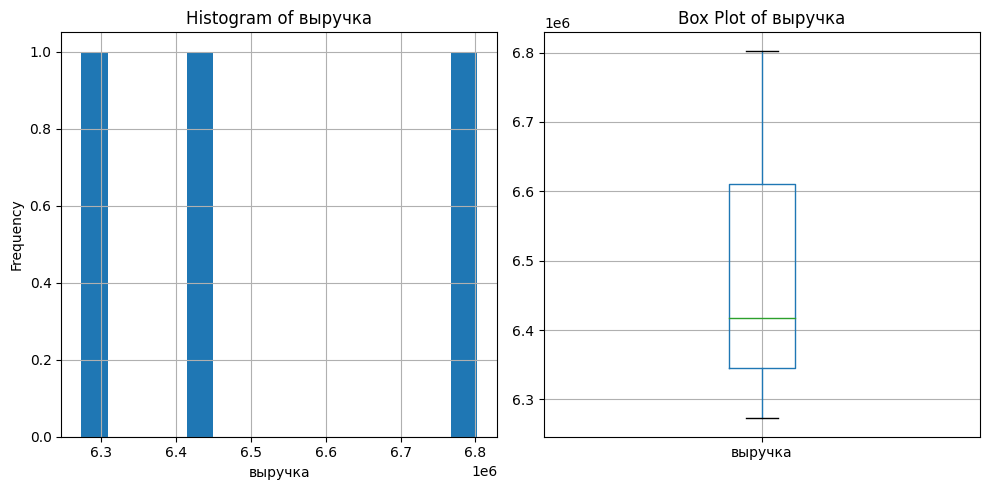

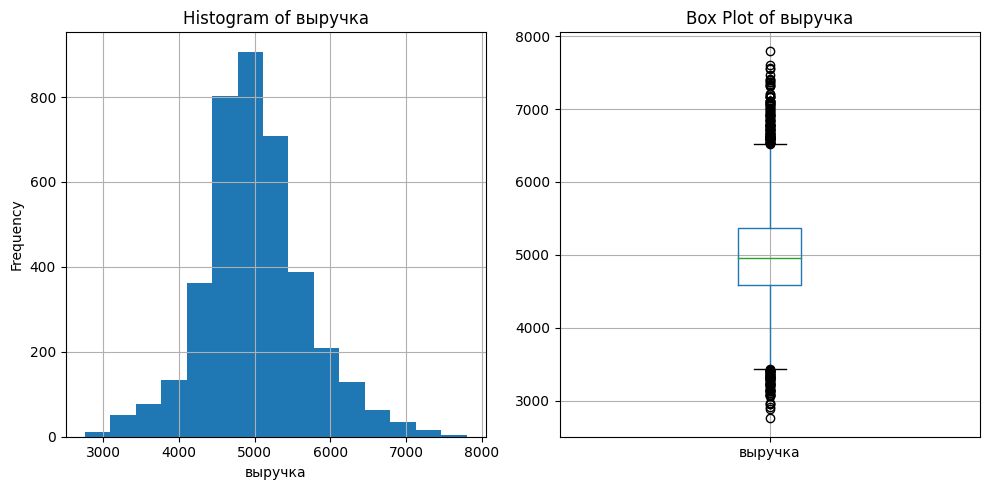

In [34]:
market_money = market_money[market_money['выручка'] != 0]
plot_histograms_boxplots(market_money.groupby(by='период_деньги').sum())
plot_histograms_boxplots(market_money)

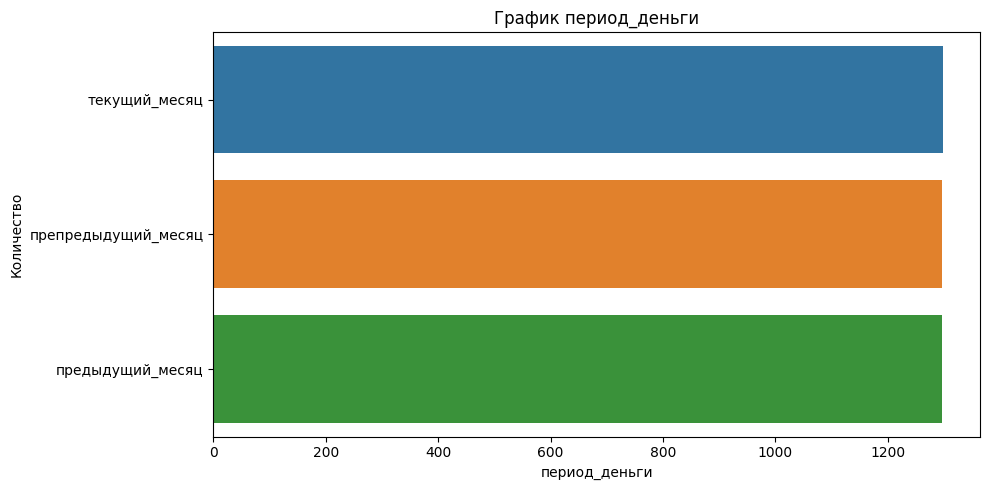

In [35]:
plot_countplots(market_money)

Из графика распределения периода видно, что в каждый период было одинаковое количество покупок. 

In [36]:
market_time.describe()

,минут
count,2600.000000
mean,13.336154
std,4.080198
min,4.000000
25%,10.000000
50%,13.000000
75%,16.000000
max,23.000000


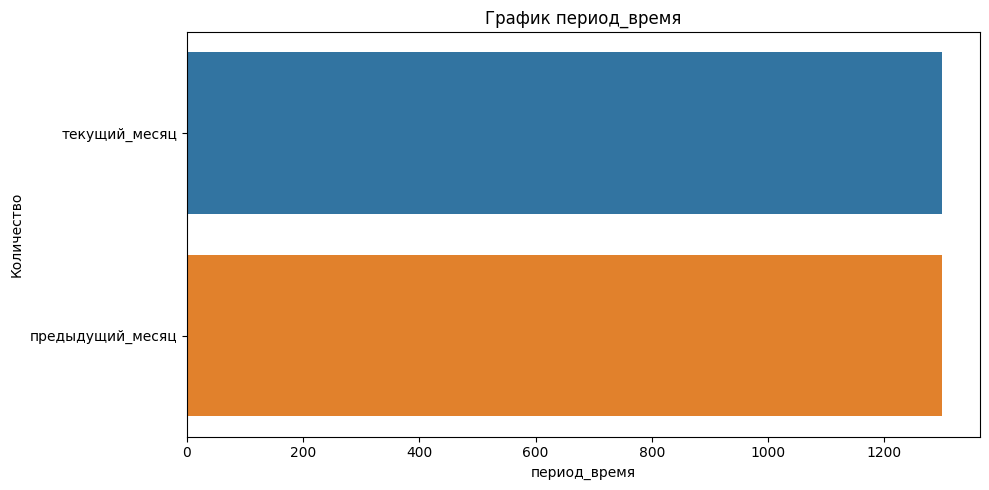

In [37]:
plot_countplots(market_time)

Из графика распределения периода видно, что в каждый период было одинаковое количество покупок.

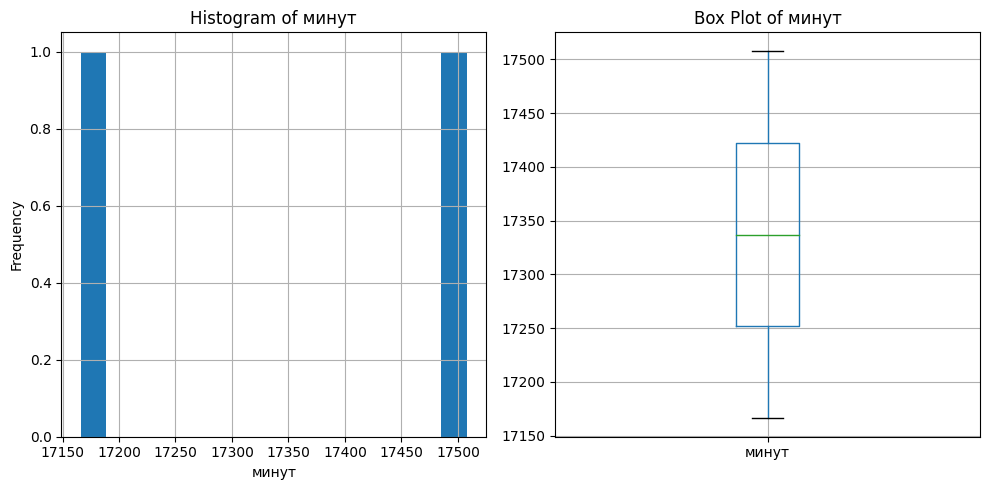

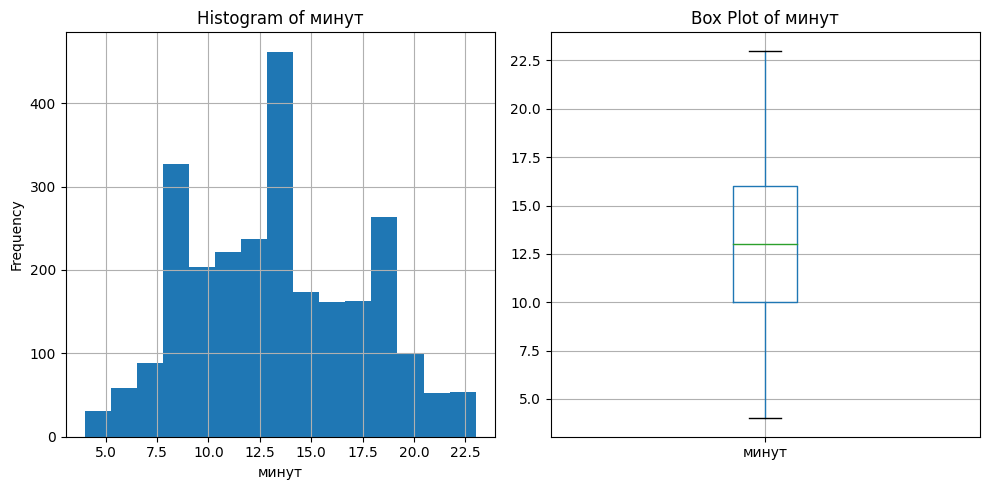

In [38]:
plot_histograms_boxplots(market_time.groupby(by='период_время').sum())
plot_histograms_boxplots(market_time)

Распределение близко к нормальному и выбросы отсутствуют.

In [39]:
money.describe()

,прибыль
count,1300.000000
mean,3.996631
std,1.013722
min,0.860000
25%,3.300000
50%,4.045000
75%,4.670000
max,7.430000


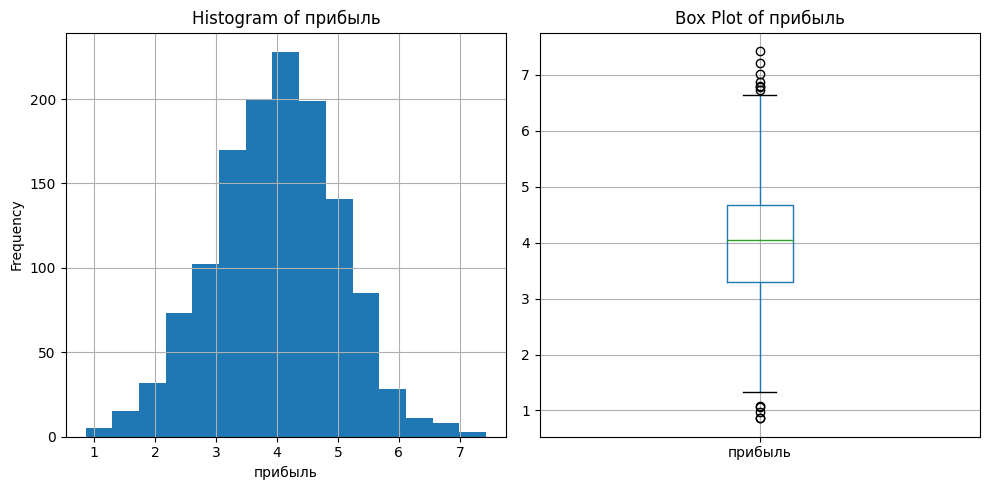

In [40]:
plot_histograms_boxplots(money)

Параметр прибыль имеет выбросы.

***Выводы:***

В данных market_file выявлено следующее:
- В параметрах маркет_актив6мес, акци_покупки, неопл_прод_штук_квартал присутствуют выбросы;
- Диаграмма для параметра маркет_актив_тек_мес выглядит так потому что уникальных значений всего 3;
- В параметрах: тип_сервиса и разр_сообщать виден дисбаланс в значениях. Тажке он есть и в целевом признаке покуп_актив.

В данных market_money в параметре выручка присутствовали сильные выбросы. Также при обработке данных выявлены и удалены неактивные пользователи.

Данные market_time близки к нормальному и выбросы отсутствуют.

В данных money в параметре прибыль присутствуют выбросы. 

## Объеденение таблиц

In [41]:
market_money = pd.pivot_table(market_money, index='id', columns='период_деньги', values='выручка').fillna(0)
market_money.columns = ['выручка_пред_месяц', 'выручка_препред_месяц', 'выручка_тек_месяц']
display(market_money)

,выручка_пред_месяц,выручка_препред_месяц,выручка_тек_месяц
id,,,
215348,0.0,0.0,3293.1
215349,5216.0,4472.0,4971.6
215350,5457.5,4826.0,5058.4
215351,6158.0,4793.0,6610.4
215352,5807.5,4594.0,5872.5
...,...,...,...
216643,3664.0,4704.0,4741.7
216644,4729.0,5299.0,5353.0
216645,5160.0,5334.0,5139.2


In [42]:
market_time = pd.pivot_table(market_time, index='id', columns='период_время', values='минут').fillna(0)
market_time.columns = ['времяпровождение_пред_месяц', 'времяпровождение_тек_месяц']
display(market_time)

,времяпровождение_пред_месяц,времяпровождение_тек_месяц
id,,
215348,13,14
215349,12,10
215350,8,13
215351,11,13
215352,8,11
...,...,...
216643,14,7
216644,12,11
216645,12,18


In [43]:
df_full = market_file.merge(market_money, on='id', how='inner').merge(market_time, on='id', how='inner')

In [44]:
df_full.head(20)

,покуп_актив,тип_сервиса,разр_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акци_покупки,поп_категория,сред_просм_катег_за_визит,неопл_прод_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_пред_месяц,выручка_препред_месяц,выручка_тек_месяц,времяпровождение_пред_месяц,времяпровождение_тек_месяц
id,,,,,,,,,,,,,,,,,
215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5,0.0,0.0,3293.1,13,14
215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11
215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10
215354,Снизилась,стандарт,да,5.1,3,431,0.23,Косметика и аксессуары,2,3,7,2,5685.0,4503.0,5869.6,11,12
215355,Снизилась,стандарт,нет,4.7,4,284,0.17,Товары для детей,5,1,6,4,3263.0,4749.0,3772.6,12,10
215356,Снизилась,стандарт,да,4.2,4,192,0.14,Косметика и аксессуары,2,2,1,3,4146.5,4433.0,4566.4,6,7


In [45]:
df_full = df_full.drop(index=[215380, 215348, 215357, 215359])

In [46]:
df_full.shape

(1296, 17)

In [47]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1296 entries, 215349 to 216647
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   покуп_актив                  1296 non-null   object 
 1   тип_сервиса                  1296 non-null   object 
 2   разр_сообщать                1296 non-null   object 
 3   маркет_актив_6_мес           1296 non-null   float64
 4   маркет_актив_тек_мес         1296 non-null   int64  
 5   длительность                 1296 non-null   int64  
 6   акци_покупки                 1296 non-null   float64
 7   поп_категория                1296 non-null   object 
 8   сред_просм_катег_за_визит    1296 non-null   int64  
 9   неопл_прод_штук_квартал      1296 non-null   int64  
 10  ошибка_сервиса               1296 non-null   int64  
 11  страниц_за_визит             1296 non-null   int64  
 12  выручка_пред_месяц           1296 non-null   float64
 13  выручка_препред_

***Вывод:*** Объеденение прошло успешно, т.к. данных типа NaN не обнаружено.

## Корреляционный анализ

interval columns not set, guessing: ['маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 'акци_покупки', 'сред_просм_катег_за_визит', 'неопл_прод_штук_квартал', 'ошибка_сервиса', 'страниц_за_визит', 'выручка_пред_месяц', 'выручка_препред_месяц', 'выручка_тек_месяц', 'времяпровождение_пред_месяц', 'времяпровождение_тек_месяц']


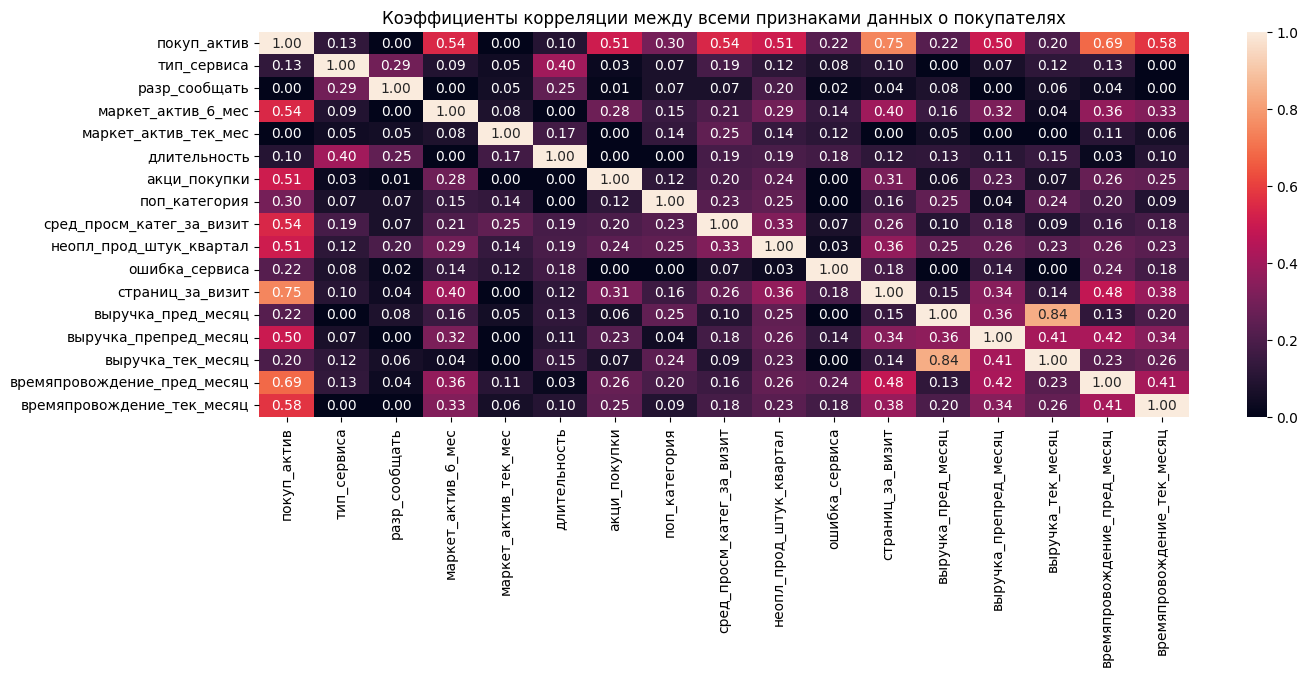

In [48]:
_phik_matrix = df_full.phik_matrix()
plt.figure(figsize=(15, 5))
sns.heatmap(_phik_matrix, annot=True, fmt=".2f");
plt.title('Коэффициенты корреляции между всеми признаками данных о покупателях');

***Вывод:*** Корреляционная матрица показала, что между некоторыми входными признаками есть умеренная корреляция, но нет явных признаков сильной мультиколлинеарности, с которой стоило бы справляться.

interval columns not set, guessing: ['маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 'акци_покупки', 'сред_просм_катег_за_визит', 'неопл_прод_штук_квартал', 'ошибка_сервиса', 'страниц_за_визит', 'выручка_пред_месяц', 'выручка_препред_месяц', 'выручка_тек_месяц', 'времяпровождение_пред_месяц', 'времяпровождение_тек_месяц']


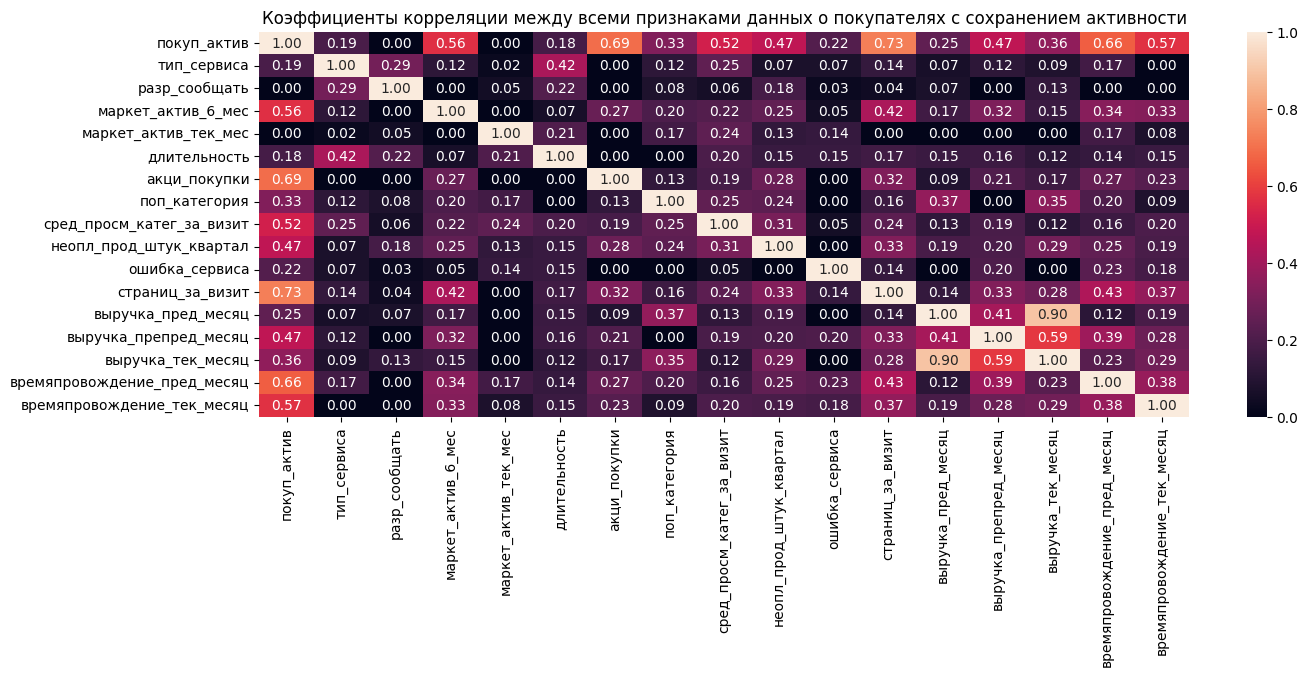

In [49]:
_phik_matrix = df_full.query('выручка_пред_месяц <= выручка_тек_месяц').phik_matrix()
plt.figure(figsize=(15, 5))
sns.heatmap(_phik_matrix, annot=True, fmt=".2f");
plt.title('Коэффициенты корреляции между всеми признаками данных о покупателях с сохранением активности');

interval columns not set, guessing: ['маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 'акци_покупки', 'сред_просм_катег_за_визит', 'неопл_прод_штук_квартал', 'ошибка_сервиса', 'страниц_за_визит', 'выручка_пред_месяц', 'выручка_препред_месяц', 'выручка_тек_месяц', 'времяпровождение_пред_месяц', 'времяпровождение_тек_месяц']


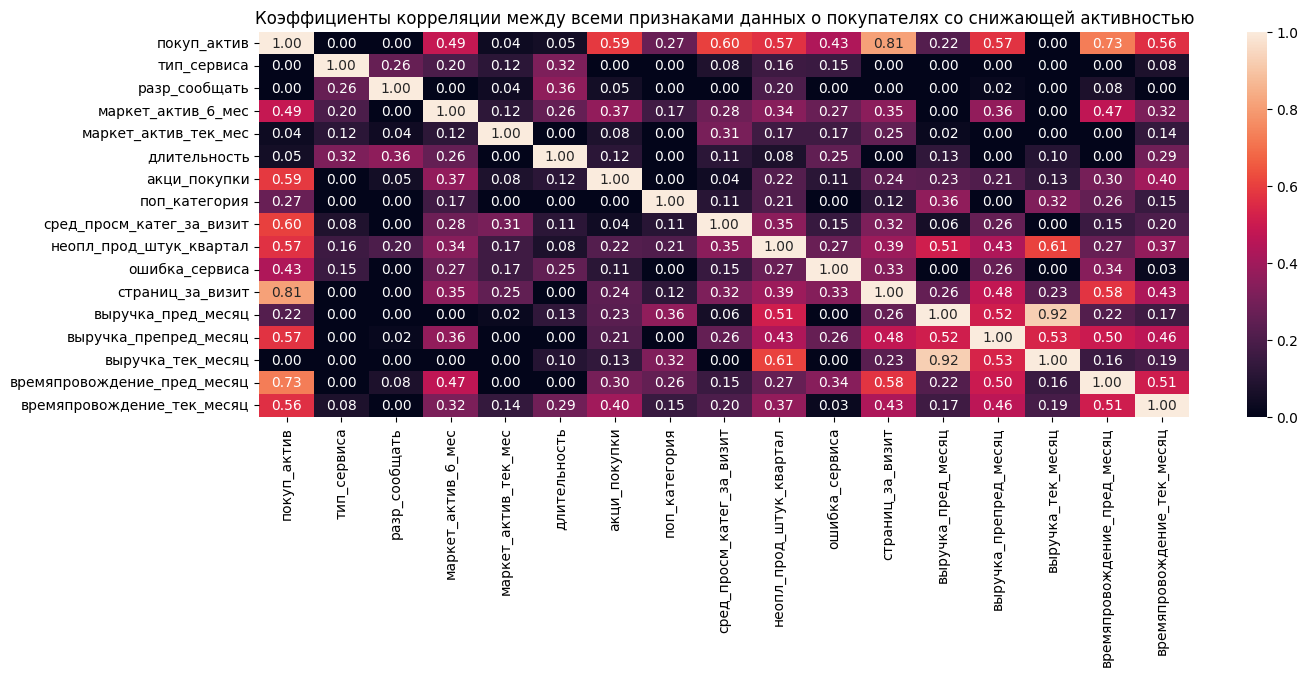

In [50]:
_phik_matrix = df_full.query('выручка_пред_месяц > выручка_тек_месяц').phik_matrix()
plt.figure(figsize=(15, 5))
sns.heatmap(_phik_matrix, annot=True, fmt=".2f");
plt.title('Коэффициенты корреляции между всеми признаками данных о покупателях со снижающей активностью');

## Использование пайплайнов

Так как данные не сбалансированы (см. раздел 3.2), поэтому для обучения модели и подбор гиперпараметров используем roc_auc.

In [51]:
encoder = LabelEncoder()

X = df_full.drop(['покуп_актив'], axis=1)
y = encoder.fit_transform(df_full['покуп_актив'])
display(y, df_full['покуп_актив'])

array([1, 1, 1, ..., 0, 0, 0])

id
215349          Снизилась
215350          Снизилась
215351          Снизилась
215352          Снизилась
215353          Снизилась
               ...       
216643    Прежний уровень
216644    Прежний уровень
216645    Прежний уровень
216646    Прежний уровень
216647    Прежний уровень
Name: покуп_актив, Length: 1296, dtype: object

In [52]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = y)

In [53]:
ohe_columns = ['поп_категория']
ord_columns = ['тип_сервиса', 'разр_сообщать']
num_columns = ['маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 'акци_покупки', 'сред_просм_катег_за_визит',
               'неопл_прод_штук_квартал', 'ошибка_сервиса', 'страниц_за_визит', 'выручка_пред_месяц', 'выручка_препред_месяц',
               'выручка_тек_месяц', 'времяпровождение_пред_месяц', 'времяпровождение_тек_месяц']

In [54]:
# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer([
    ('ohe', OneHotEncoder(drop='first', handle_unknown='error'), ohe_columns),
    ('ord', OrdinalEncoder(), ord_columns),
    ('num', StandardScaler(), num_columns)
], remainder='passthrough')

# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 5),
        'models__max_features': range(2, 5)
    },
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(5, 100)
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE)],
        'models__C': [0.1, 1.0, 10.0, 100.0]
    },
    # словарь для модели SVC()
    {
        'models': [SVC(probability=True)],
        'models__kernel': ['linear', 'rbf']
    }
]

randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)

# проверьте работу модели на тестовой выборке
# рассчитайте прогноз на тестовых данных
y_test_pred = randomized_search.predict_proba(X_test)
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_pred[:, 1])}')

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(drop='first'),
                                                  ['поп_категория']),
                                                 ('ord', OrdinalEncoder(),
                                                  ['тип_сервиса',
                                                   'разр_сообщать']),
                                                 ('num', StandardScaler(),
                                                  ['маркет_актив_6_мес',
                                                   'маркет_актив_тек_мес',
                                                   'длительность',
                                                   'акци_покупки',
                                                   'сред_просм_катег_за_визит',
                     

***Вывод:*** Лучшая моделью является KNeighborsClassifier с числом ближайших соседей равным 26. Также лучшее значение метрики ROC-AUC на тестовой выборке равно 0.921802278927941.

## Анализ важности признаков

  0%|          | 0/10 [00:00<?, ?it/s]

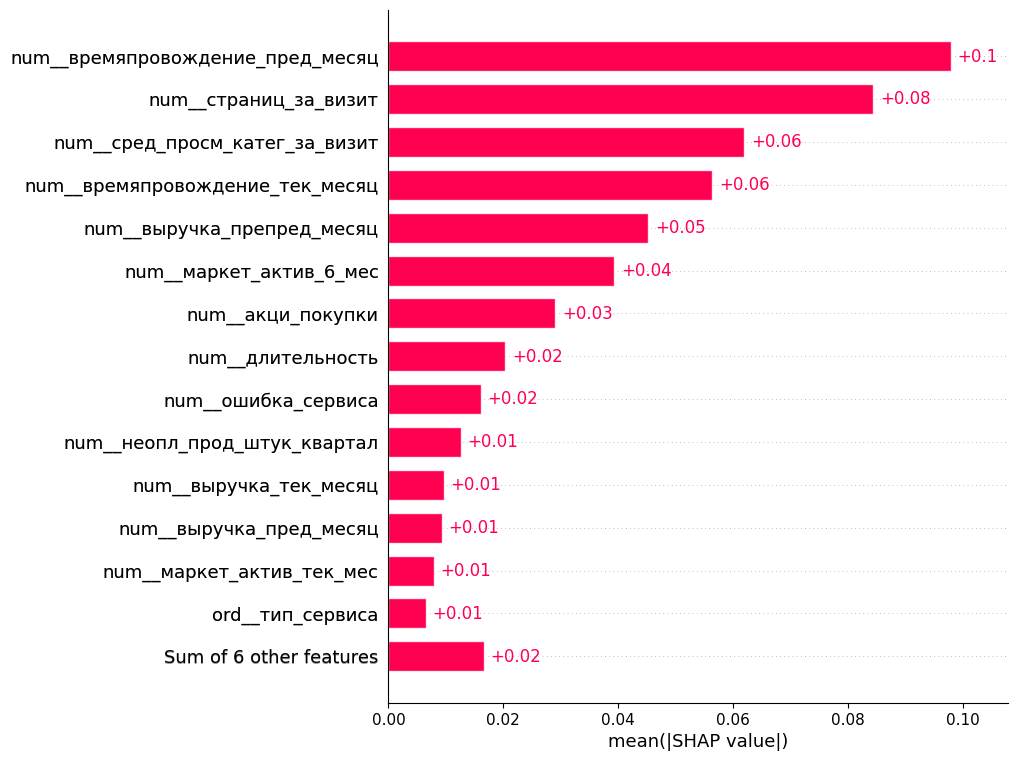

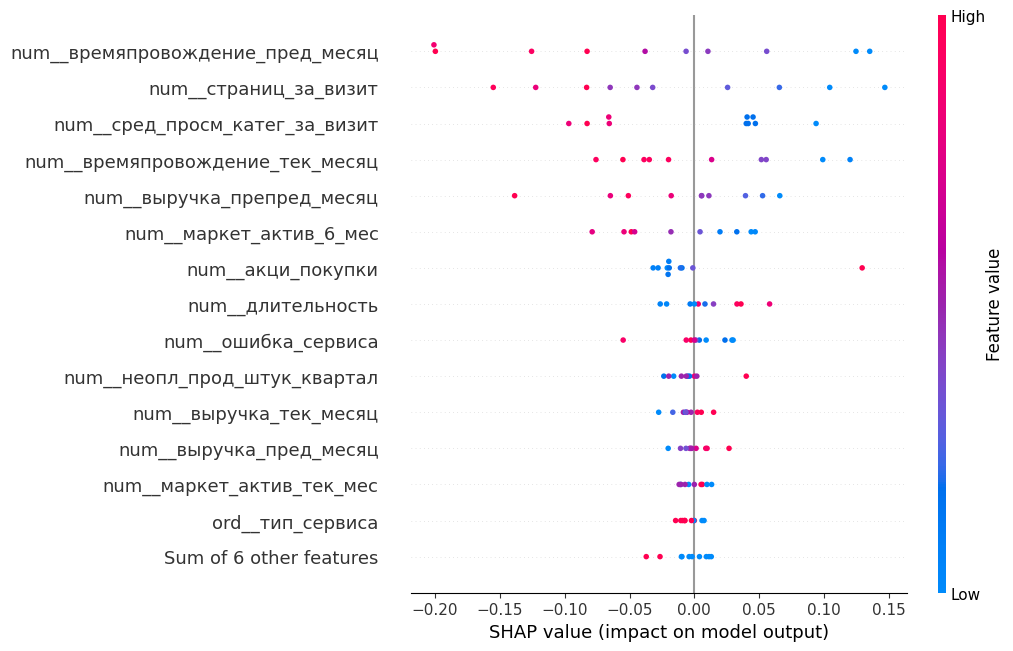

In [55]:
# Подготовка данных
X_train_2 = pipe_final.named_steps['preprocessor'].fit_transform(X_train)
X_test_2 = pipe_final.named_steps['preprocessor'].transform(X_test)
feature_names = pipe_final.named_steps['preprocessor'].get_feature_names_out()
X_test_2 = pd.DataFrame(X_test_2, columns=feature_names)

# Создание объекта KernelExplainer с вероятностями для одного класса
best_model = randomized_search.best_estimator_.named_steps['models']
best_model.fit(X_train_2, y_train)
explainer = shap.KernelExplainer(lambda x: best_model.predict_proba(x), shap.sample(X_train_2, 10))

# Рассчет SHAP значений для тестовых данных
shap_values = explainer(shap.sample(X_test_2, 10))

# Визуализация
shap.plots.bar(shap_values[:, :, 1], max_display=15)
shap.plots.beeswarm(shap_values[:, :, 1], max_display=15)

***Выводы:*** 

1. Наиболее значимый признак для модели это времяпровождение_тек_месяц (0.09);
2. Наименее значимые признаки для модели это маркет_актив_тек_мес и выручка_тек_месяц;
3. При принятии бизнес-решений эти выводы можно использовать при рассылке пользователям страниц с товарами и при предложении различных акций.

## Сегментация покупателей

Маркет_актив_тек_мес и выручка_тек_месяц не показали высокую значимость на графиках shap, но если приглядеться, то на графике beeswarm мы видим очень четкое разделение: времяпровождение_тек_месяц - высокая вероятность снижения, значит мы можем отследить данный параметр и выявить по нему пользователей со снижающейся активностью. 

### Выполним сегментацию покупателей

In [56]:
threshold = 0.9

# Применим модель для всех данных
best_model = randomized_search.best_estimator_
predictions = best_model.predict_proba(X)[:, 1]
prediction_flags = np.where(predictions > threshold, True, False)

In [57]:
# Выберем только те данные для которых модель предсказала снижение
df_decline = df_full.loc[prediction_flags]

# Добавить в эти данные инфу о прибыльности из таблицы money
df_decline = df_decline.join(money, on='id')

# Проверим что появился столбец
df_decline.info()

<class 'pandas.core.frame.DataFrame'>
Index: 213 entries, 215349 to 215745
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   покуп_актив                  213 non-null    object 
 1   тип_сервиса                  213 non-null    object 
 2   разр_сообщать                213 non-null    object 
 3   маркет_актив_6_мес           213 non-null    float64
 4   маркет_актив_тек_мес         213 non-null    int64  
 5   длительность                 213 non-null    int64  
 6   акци_покупки                 213 non-null    float64
 7   поп_категория                213 non-null    object 
 8   сред_просм_катег_за_визит    213 non-null    int64  
 9   неопл_прод_штук_квартал      213 non-null    int64  
 10  ошибка_сервиса               213 non-null    int64  
 11  страниц_за_визит             213 non-null    int64  
 12  выручка_пред_месяц           213 non-null    float64
 13  выручка_препред_м

In [58]:
# Выберем только те данные для которых модель предсказала снижение
df_no_decline = df_full.loc[prediction_flags == False]

# Добавить в эти данные инфу о прибыльности из таблицы money
df_no_decline = df_no_decline.join(money, on='id')

# Проверим что появился столбец
df_no_decline.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1083 entries, 215350 to 216647
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   покуп_актив                  1083 non-null   object 
 1   тип_сервиса                  1083 non-null   object 
 2   разр_сообщать                1083 non-null   object 
 3   маркет_актив_6_мес           1083 non-null   float64
 4   маркет_актив_тек_мес         1083 non-null   int64  
 5   длительность                 1083 non-null   int64  
 6   акци_покупки                 1083 non-null   float64
 7   поп_категория                1083 non-null   object 
 8   сред_просм_катег_за_визит    1083 non-null   int64  
 9   неопл_прод_штук_квартал      1083 non-null   int64  
 10  ошибка_сервиса               1083 non-null   int64  
 11  страниц_за_визит             1083 non-null   int64  
 12  выручка_пред_месяц           1083 non-null   float64
 13  выручка_препред_

### Методы увеличения покупательской активности

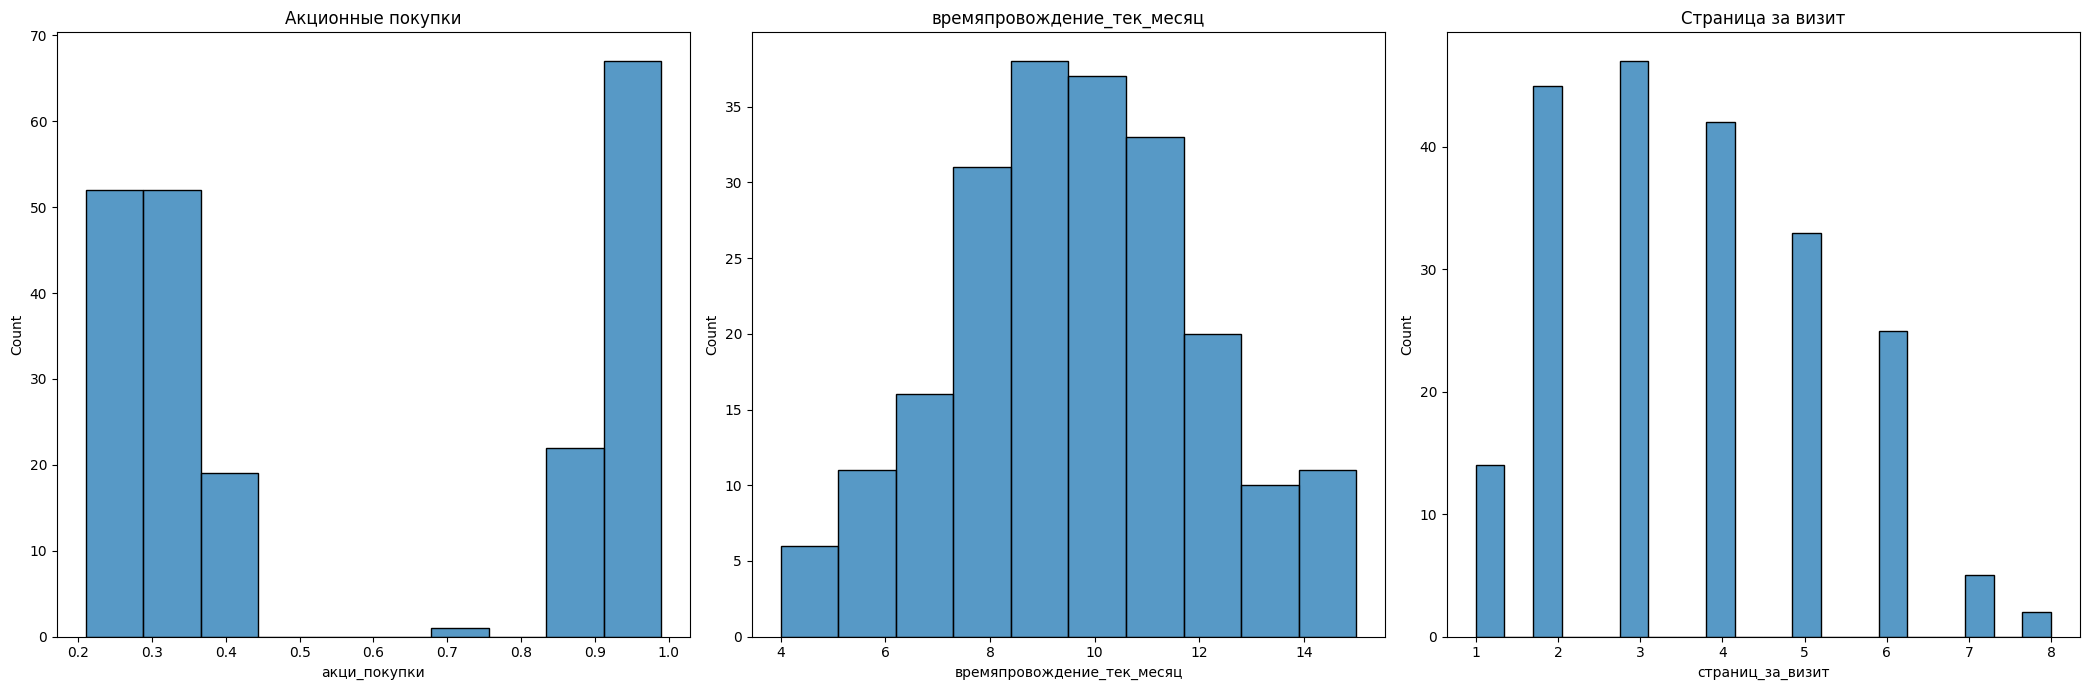

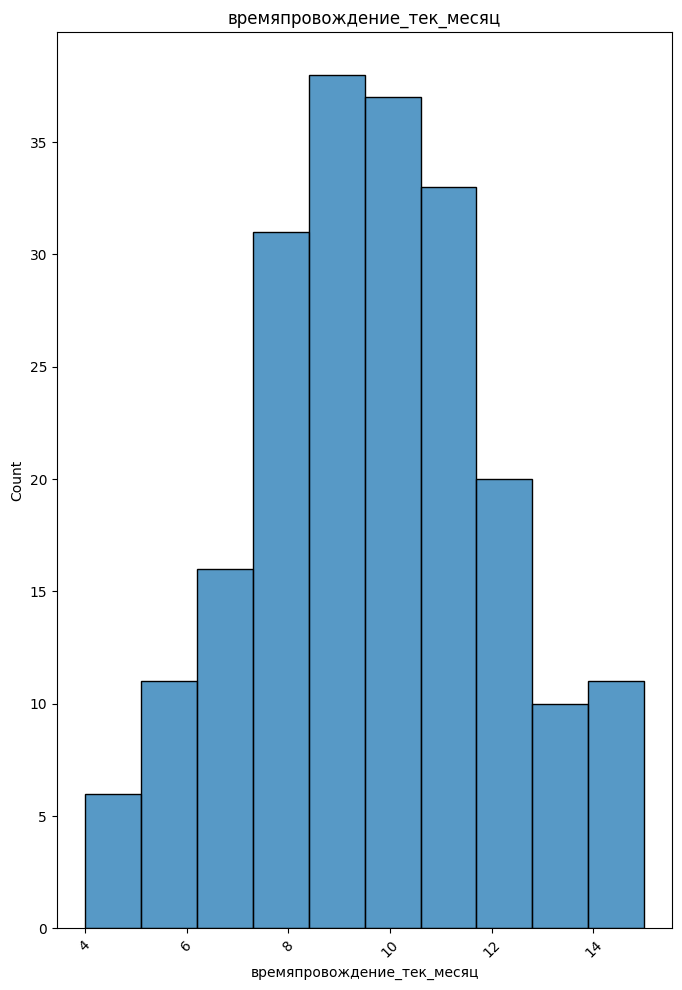

In [59]:
# У нас есть уже список параметров которые влияют на снижение покупательской активности. 
# Возьмем первые 5 и выделим группу на основе них
# Акционные_покупки, времяпровождение_тек_месяц, Страниц_за_визит, времяпровождение_пред_месяц, Популярная_категория

plt.figure(figsize=(21, 7))

plt.subplot(1, 3, 1)
sns.histplot(df_decline['акци_покупки'], bins=10)
plt.title('Акционные покупки')

plt.subplot(1, 3, 2)
sns.histplot(df_decline['времяпровождение_тек_месяц'], bins=10)
plt.title('времяпровождение_тек_месяц')

plt.subplot(1, 3, 3)
sns.histplot(df_decline['страниц_за_визит'], bins=20)
plt.title('Страница за визит')

plt.tight_layout()
plt.show()

plt.figure(figsize=(20, 10))

plt.subplot(1, 3, 2)
sns.histplot(df_decline['времяпровождение_тек_месяц'], bins=10)
plt.title('времяпровождение_тек_месяц')


plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

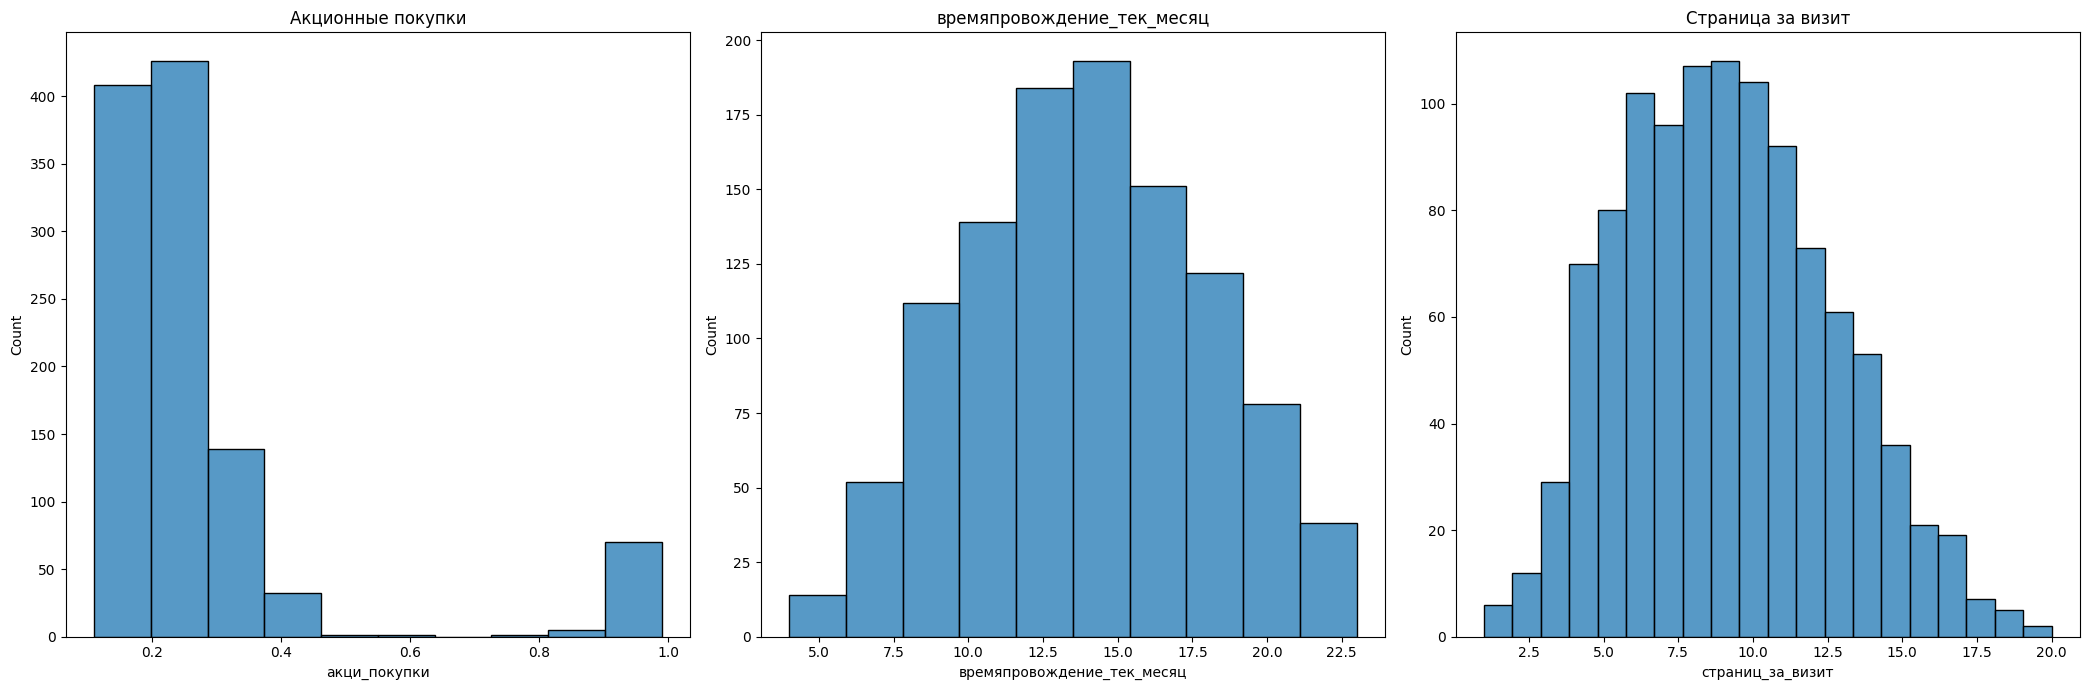

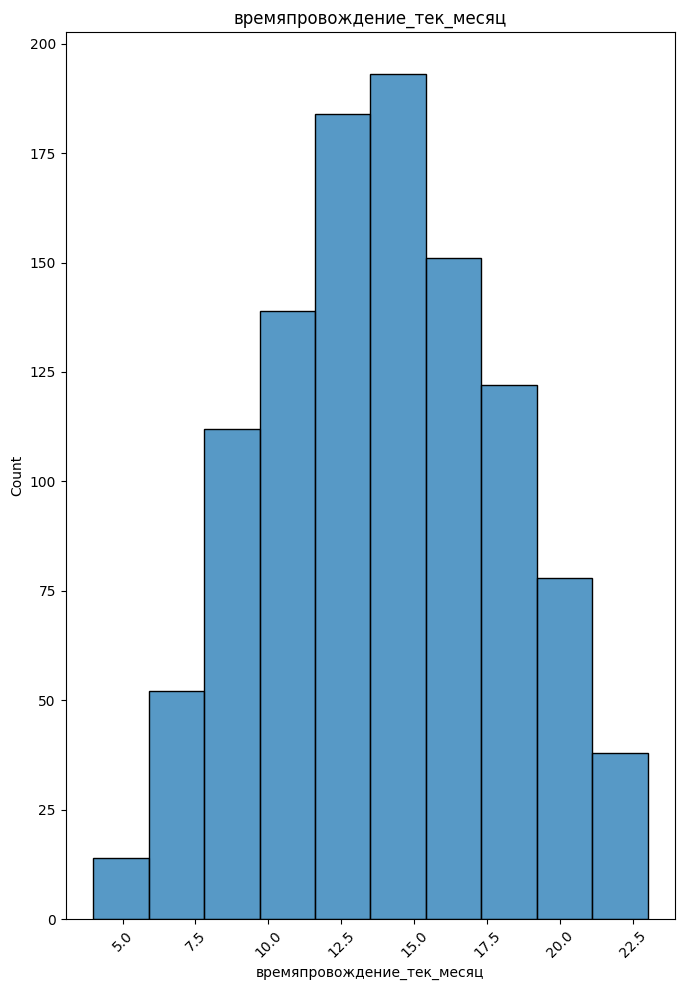

In [60]:
# У нас есть уже список параметров которые влияют на снижение покупательской активности. 
# Возьмем первые 5 и выделим группу на основе них
# Акционные_покупки, времяпровождение_тек_месяц, Страниц_за_визит, времяпровождение_пред_месяц, Популярная_категория

plt.figure(figsize=(21, 7))

plt.subplot(1, 3, 1)
sns.histplot(df_no_decline['акци_покупки'], bins=10)
plt.title('Акционные покупки')

plt.subplot(1, 3, 2)
sns.histplot(df_no_decline['времяпровождение_тек_месяц'], bins=10)
plt.title('времяпровождение_тек_месяц')

plt.subplot(1, 3, 3)
sns.histplot(df_no_decline['страниц_за_визит'], bins=20)
plt.title('Страница за визит')

plt.tight_layout()
plt.show()

plt.figure(figsize=(20, 10))

plt.subplot(1, 3, 2)
sns.histplot(df_no_decline['времяпровождение_тек_месяц'], bins=10)
plt.title('времяпровождение_тек_месяц')


plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

***Выводы:*** 

На основании графиков выше видно, что активность пользователя снизится, если:

1. Среднее число просмотренных категорий за визит очень маленькое;
2. Маленькое количество просмотренных страниц за визит;
3. В целом небольшое времяпровождение на сайте;
4. Большое количество неоплаченных покупок;
5. Низкая выручка за позапрошлый месяц.

## Общий вывод

В начале проекта были поставлены следующие задачи:

1. Построить модель для предсказания снижения покупательской активности;
2. Используя данные модели и данные о прибыльности клиентов, выделить сегменты покупателей и разработать для них персонализированные предложения.

В качестве данных были предоставлены 4 таблицы:

- market_file.csv. Таблица с данными о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении;
- market_money.csv. Таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом;
- market_time.csv. Таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода;
- money.csv. Таблица с данными о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.

Для поиска лучшей модели были проделаны следующие шаги:

1. изучены данные;
2. обработаны пропуски и дубликаты;
3. исследованы на качество, проверены на выбросы и аномалии;
4. исследованы взаимосвязи количественных признаков с помощью корреляционного анализа;
5. объединены данные чтобы у модели были больше признаков для обучени;
6. настроенна автоматизация обучения с помощью пайпдайнов;
7. лучшая модель оказалась KNeighborsClassifier

На основе выбранной модели был построен график с параметрами, которые сильнее всего влияют предсказание. На основе этих параметров был сделан вывод, что при снижении покупательской активности стоит акцентировать внимание пользователей на акционные товары в самых просматриваемых категориях.